# Load Data 

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [1]:
!pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 6.5 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 9.7 MB/s eta 0:00:00
     -------------------------------------- 440.7/440.7 kB 9.2 MB/s eta 0:00:00
     -------------------------------------- 126.5/126.5 kB 7.3 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 11.7 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 65.5/65.5 kB ? eta 0:00:00
     -------------------------------------- 422.5/422.5 kB 8.8 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     ---------------------------------------- 5

In [4]:
# Read the CSV file containing the labels
data = pd.read_csv('./pollen_data.csv', usecols=['filename', 'pollen_carrying'])
data

filename  pollen_carrying
0     P10057-125r.jpg                1
1     P57380-120r.jpg                1
2    NP63671-221r.jpg                0
3     NP53776-47r.jpg                0
4    NP13382-201r.jpg                0
..                ...              ...
709  NP64239-233r.jpg                0
710  NP10304-132r.jpg                0
711  NP28671-238r.jpg                0
712   P14163-218r.jpg                1
713    NP1768-11r.jpg                0

[714 rows x 2 columns]

In [5]:
folder_path = "./asset/images/"
for filename in os.listdir(folder_path):
    image_path = os.path.join(folder_path, filename)

    image = cv2.imread(image_path)

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    resized_image = cv2.resize(gray_image, (100, 100))

    blurred_image = cv2.GaussianBlur(resized_image, (5, 5), 0)


    processed_image_path = os.path.join("./assets/images/", filename)
    cv2.imwrite(processed_image_path, gray_image)

In [6]:
def preprocess_df(df):
    df = df.copy()
    
    # Change filenames into filepaths
    image_path = './asset/images/'
    
    # Change col filename to path images
    df['filename'] = df['filename'].apply(lambda x: image_path / Path(x)).astype(str)
    
    # Create text labels for the images (1 is Pollen, 2 is No Pollen)
    df['pollen_carrying'] = df['pollen_carrying'].map({0: "No Pollen", 1: "Pollen"})
    
    # Train-test split
    df_train, df_test = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)
    
    return df_train, df_test

In [7]:
# Get preprocessed dataframes
df_train, df_test = preprocess_df(data)


In [8]:
# Create training generator
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Create test generator
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)


In [9]:
# Generate training images
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=40,
    shuffle=True,
    seed=42,
    subset='training'
)

# Generate validation images
val_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=40,
    shuffle=True,
    seed=42,
    subset='validation'
)

# Generate test images
test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='filename',
    y_col='pollen_carrying',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=40,
    shuffle=False
)

Found 457 validated image filenames belonging to 2 classes.
Found 114 validated image filenames belonging to 2 classes.
Found 143 validated image filenames belonging to 2 classes.


In [10]:
# First batch shape
test_images[2][0].shape # [batch number][0: image array / 1: label]

(40, 224, 224, 3)

In [11]:
print("Train set rows: {}".format(df_train.shape[0]))
print("Test  set rows: {}".format(df_test.shape[0]))

Train set rows: 571
Test  set rows: 143


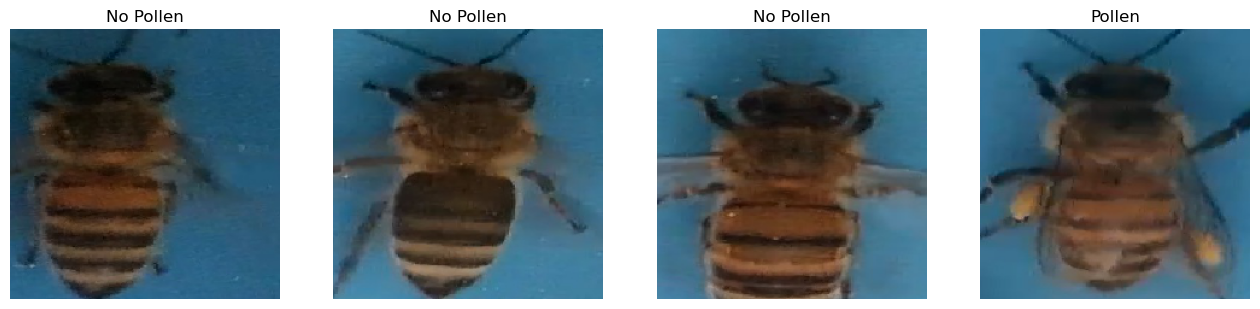

In [12]:
# Display of a few examples
plt.figure(figsize=(16, 8))

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(test_images[0][0][i+10])
    plt.title("No Pollen" if test_images.labels[i+10] == 0 else "Pollen")
    plt.axis('off')
    
plt.show()

In [13]:

# Extract the features
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Classifier (standard neural network)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)



In [14]:
# Create the model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# History
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
12/12 [==============================] - 8s 609ms/step - loss: 0.6949 - accuracy: 0.5098 - val_loss: 0.6925 - val_accuracy: 0.5088
Epoch 2/20
12/12 [==============================] - 6s 529ms/step - loss: 0.6922 - accuracy: 0.5208 - val_loss: 0.6917 - val_accuracy: 0.5088
Epoch 3/20
12/12 [==============================] - 6s 534ms/step - loss: 0.6903 - accuracy: 0.5383 - val_loss: 0.6901 - val_accuracy: 0.5088
Epoch 4/20
12/12 [==============================] - 8s 631ms/step - loss: 0.6857 - accuracy: 0.5514 - val_loss: 0.6927 - val_accuracy: 0.5088
Epoch 5/20
12/12 [==============================] - 8s 638ms/step - loss: 0.6769 - accuracy: 0.5864 - val_loss: 0.6711 - val_accuracy: 0.5702
Epoch 6/20
12/12 [==============================] - 8s 661ms/step - loss: 0.6457 - accuracy: 0.6674 - val_loss: 0.6276 - val_accuracy: 0.7105
Epoch 7/20
12/12 [==============================] - 8s 675ms/step - loss: 0.5787 - accuracy: 0.7265 - val_loss: 0.5572 - val_accuracy: 0.7456
Epoch 

In [15]:
# Print accuracy (Percentage of correct predictions)
results = model.evaluate(test_images, verbose=1)
print("Accuracy: {:.2f} %".format(results[1] * 100))

4/4 [==============================] - 1s 123ms/step - loss: 0.3017 - accuracy: 0.8951
Accuracy: 89.51 %


4/4 [==============================] - 1s 121ms/step


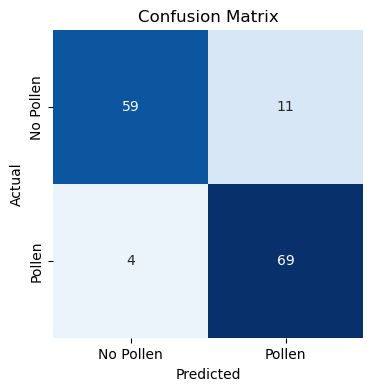

Classification Report:
----------------------
               precision    recall  f1-score   support

   No Pollen       0.94      0.84      0.89        70
      Pollen       0.86      0.95      0.90        73

    accuracy                           0.90       143
   macro avg       0.90      0.89      0.89       143
weighted avg       0.90      0.90      0.89       143



In [16]:
# Confusion matrix and classification report
predictions = np.squeeze(model.predict(test_images) >= 0.5).astype(int)
cm = confusion_matrix(test_images.labels, predictions, labels=[0, 1])
clr = classification_report(test_images.labels, predictions, labels=[0, 1], target_names=["No Pollen", "Pollen"])
# Display
plt.figure(figsize=(4, 4))

sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
plt.yticks(ticks=[0.5, 1.5], labels=["No Pollen", "Pollen"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

print("Classification Report:\n----------------------\n", clr)

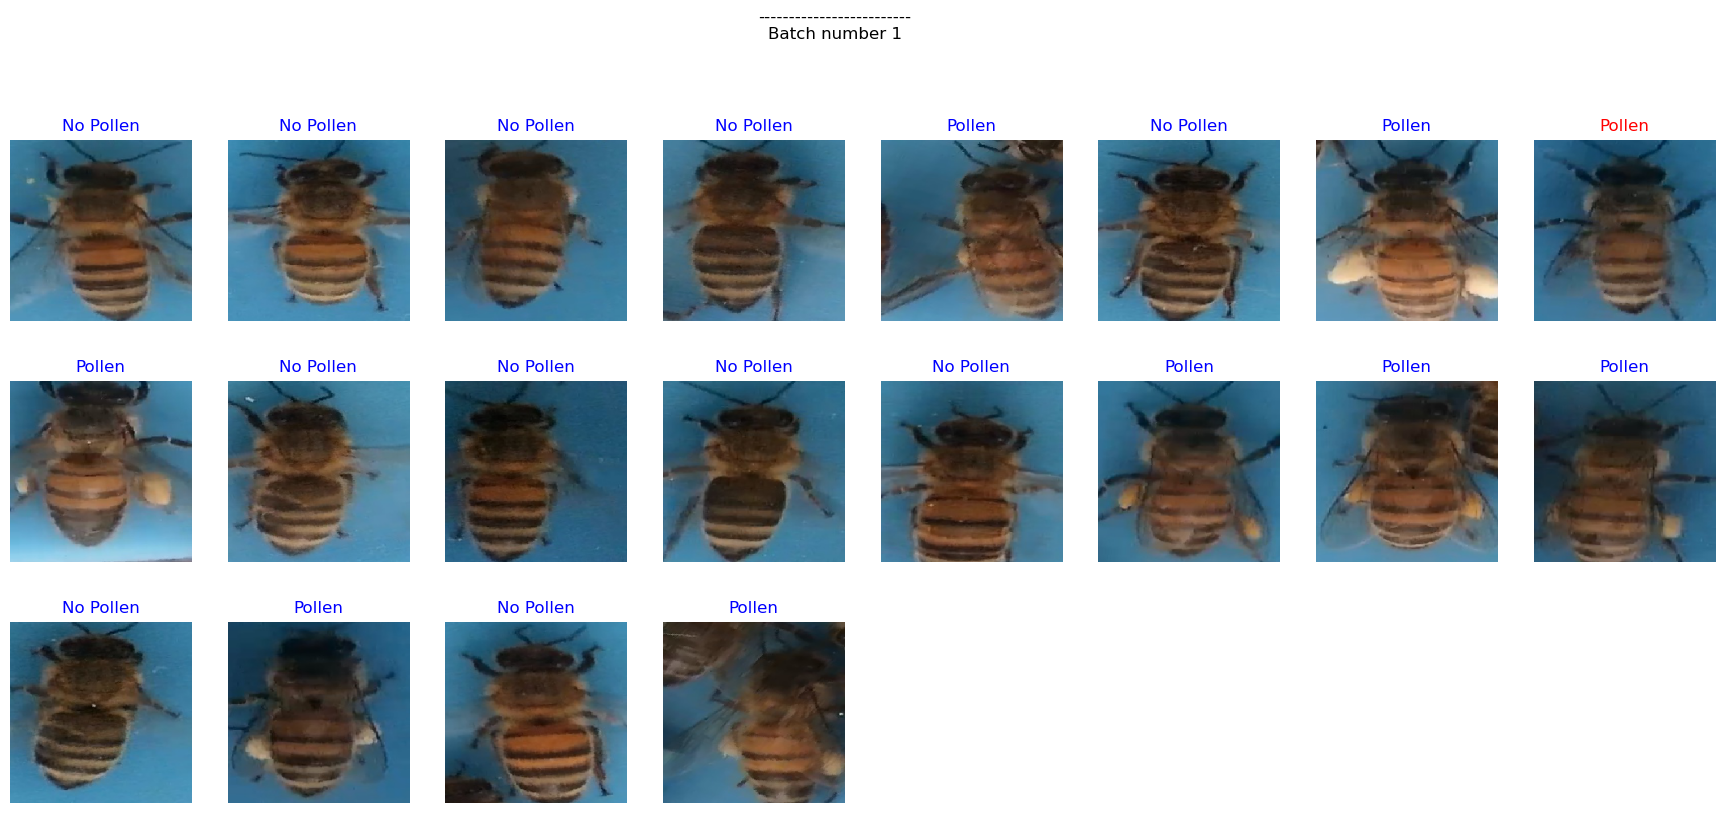

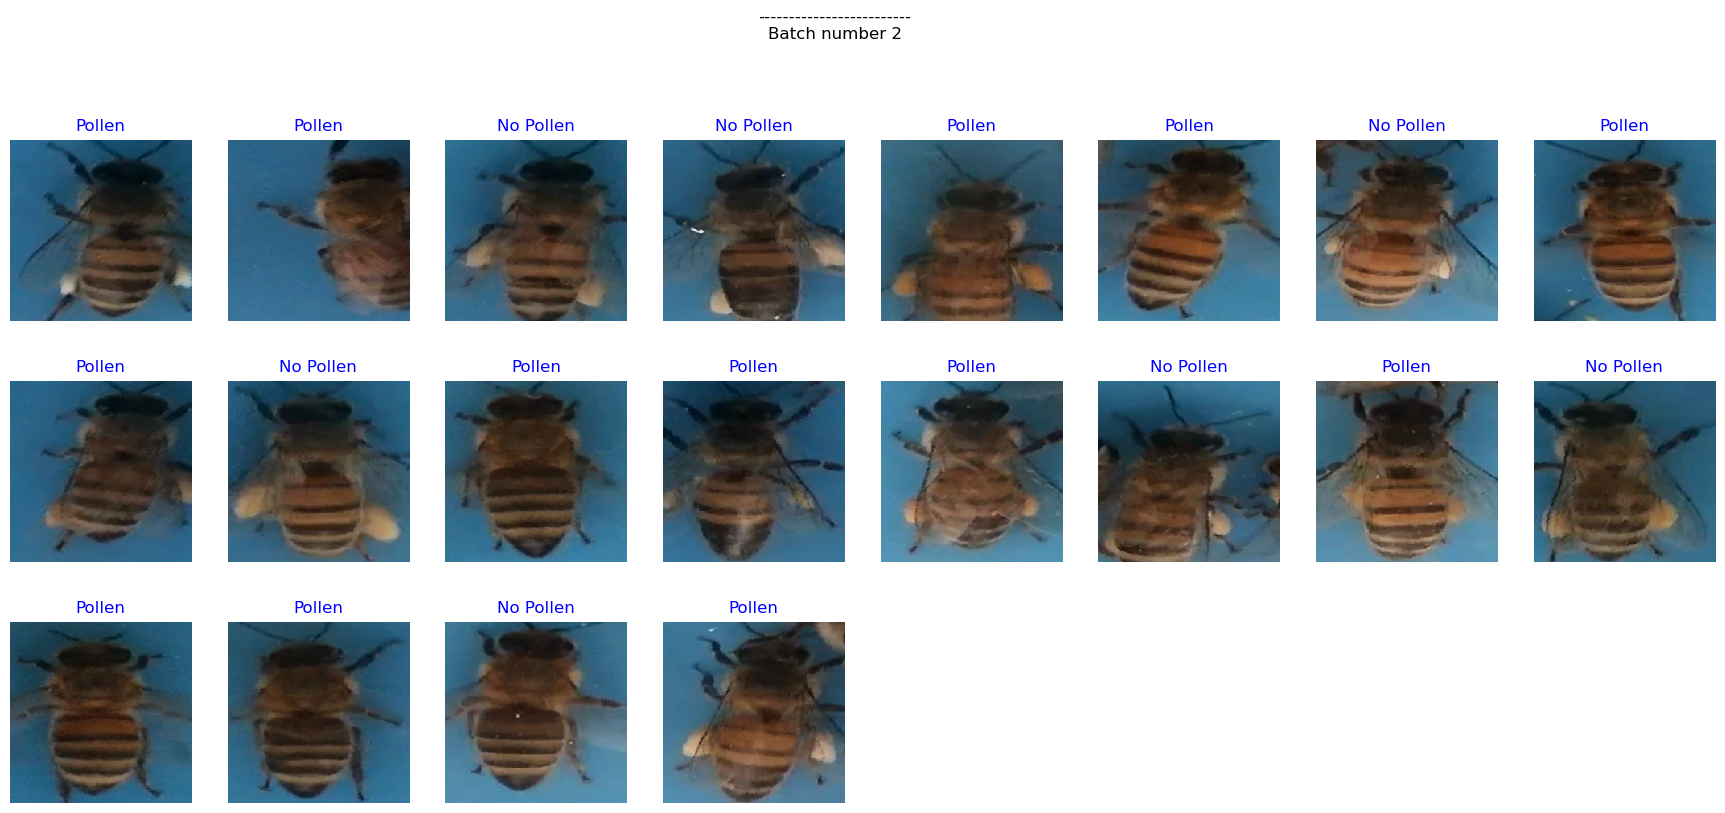

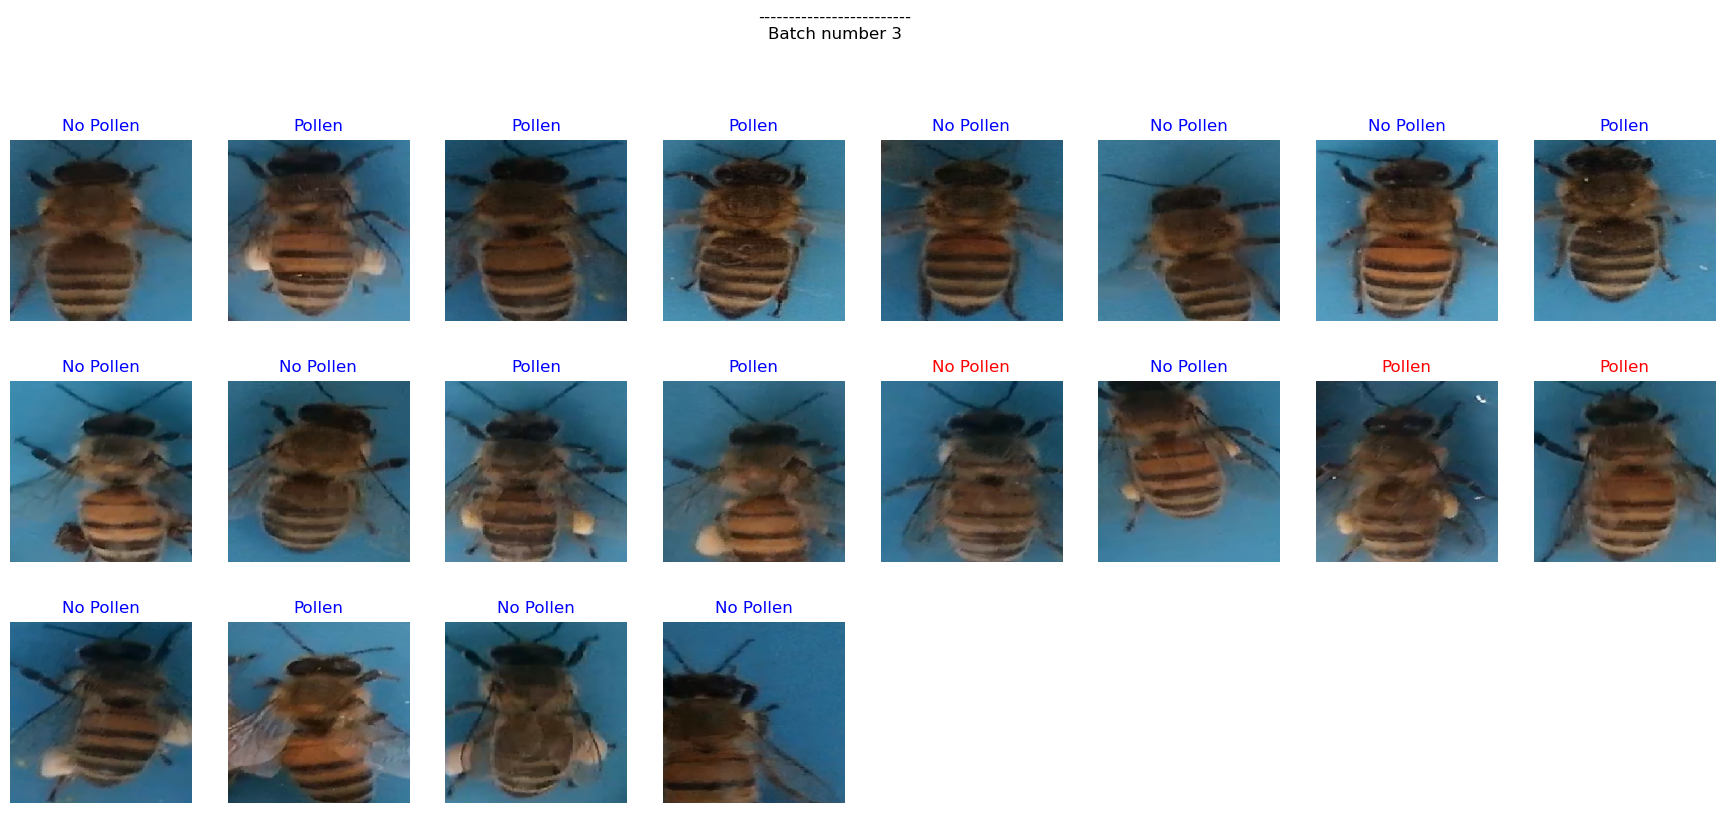

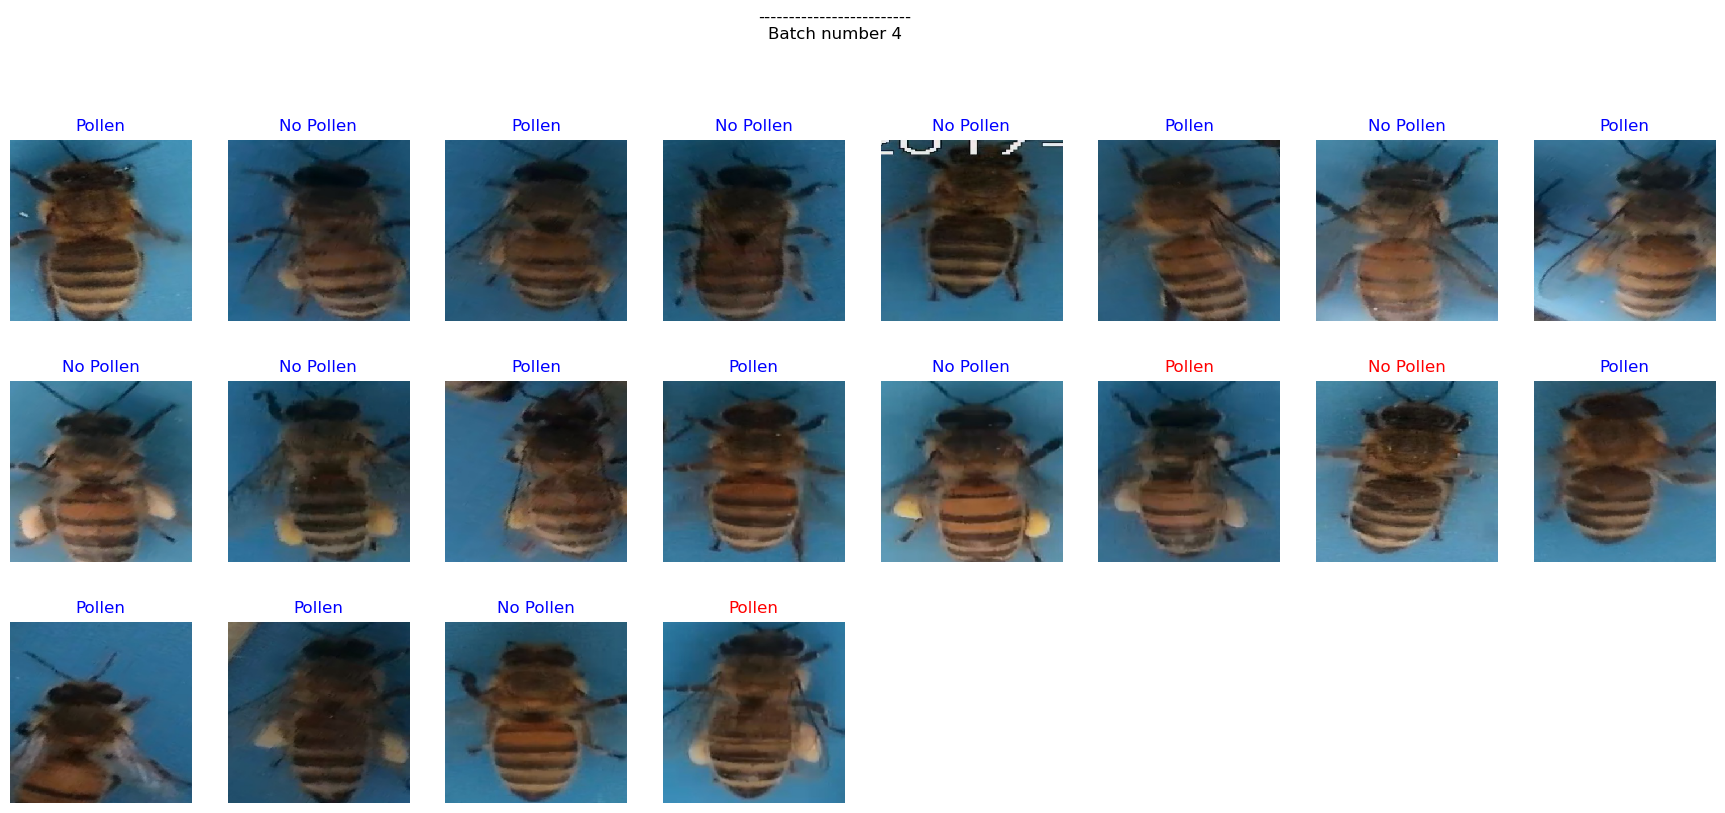

In [17]:
# Batch predictions
for batch in range(4):
    
    plt.figure(figsize=(22, 12))
    plt.suptitle(f"-------------------------\nBatch number {batch + 1}")
    
    for i in range(20):
        plt.subplot(4, 8, i+1)
        plt.imshow(test_images[batch][0][i])
        plt.title("No Pollen" if predictions[i+32*batch] == 0 else "Pollen",
                 color='blue' if predictions[i+32*batch] == test_images.labels[i+32*batch] else 'red')
        plt.axis('off')
    
plt.show()

In [ ]:
import cv2
import numpy as np
import os
### main
def pollen_detection(image):
    lower_threshold = np.array([110, 110, 110])  # Giá trị ngưỡng thấp
    upper_threshold = np.array([255, 255, 255])  # Giá trị ngưỡng cao
    segmented_image = cv2.inRange(image, lower_threshold, upper_threshold)
    data = []
    

    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Lấy hình chữ nhật bao quanh contour
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Phấn hoa thường có kích thước nhỏ hơn một ngưỡng nào đó
        threshold_area = 100  # Ngưỡng diện tích để xác định phấn hoa
        if area > threshold_area:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            pollen_carrying = 1
        else:
            pollen_carrying = 0
    return image, pollen_carrying


folder_path = './asset/images/'  # Đường dẫn đến thư mục chứa ảnh
output_folder = './assets/images/'  # Đường dẫn đến thư mục lưu ảnh kết quả

# Lấy danh sách tất cả các file ảnh trong thư mục
image_files = os.listdir(folder_path)

for image_file in image_files:
    image_path = os.path.join(folder_path, image_file)

    file_path = 'pollen_data.csv'
    df = pd.read_csv(file_path)
    input_image = cv2.imread(image_path)
    result_image, pollen_carrying = pollen_detection(input_image)
    df.loc[df['filename'] == image_path, 'pollen_carying_predict'] = pollen_carrying
    df.to_csv('output_file.csv', index=False)
    cv2.imshow('Pollen Detection Result', result_image)
    #cv2.imshow('Pollen Detection Result', result_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


    
    # Lưu ảnh kết quả vào thư mục đầu ra
    output_path = os.path.join(output_folder, image_file)
    cv2.imwrite(output_path, result_image)

In [12]:
import cv2
import numpy as np
import os

def pollen_detection(image):
    lower_threshold = np.array([110, 110, 110])  # Giá trị ngưỡng thấp
    upper_threshold = np.array([255, 255, 255])  # Giá trị ngưỡng cao
    segmented_image = cv2.inRange(image, lower_threshold, upper_threshold)

    # Trích xuất đặc trưng
    # Ví dụ: tính toán kích thước của vùng phấn hoa
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Lấy hình chữ nhật bao quanh contour
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Phấn hoa thường có kích thước nhỏ hơn một ngưỡng nào đó
        threshold_area = 100  # Ngưỡng diện tích để xác định phấn hoa
        if area > threshold_area:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)



    return segmented_image


    image_path = 'P7466-93r.jpg'  # Đường dẫn đến thư mục lưu ảnh kết quả


    # Đọc ảnh đầu vào
    input_image = cv2.imread(image_path)

    # Phát hiện phấn hoa trong ảnh và tính xác suất
    result_image = pollen_detection(input_image)
    print("setting")
    # Hiển thị ảnh kết quả
    #cv2.imshow('Pollen Detection Result', result_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()


In [10]:
import cv2
import numpy as np
import os
import pandas as pd
from openpyxl import load_workbook
def pollen_detection(image, image_path):
    lower_threshold = np.array([110, 110, 110])  # Giá trị ngưỡng thấp
    upper_threshold = np.array([255, 255, 255])  # Giá trị ngưỡng cao
    segmented_image = cv2.inRange(image, lower_threshold, upper_threshold)
    data = []
    

    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        # Lấy hình chữ nhật bao quanh contour
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)

        # Phấn hoa thường có kích thước nhỏ hơn một ngưỡng nào đó
        threshold_area = 100  # Ngưỡng diện tích để xác định phấn hoa
        if area > threshold_area:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            pollen_carrying = 1
        else:
            pollen_carrying = 0
    return image, pollen_carrying


image_path = 'P7466-93r.jpg'
file_path = 'pollen_data.csv'
df = pd.read_csv(file_path)
input_image = cv2.imread(image_path)
result_image, pollen_carrying = pollen_detection(input_image, image_path)
df.loc[df['filename'] == image_path, 'pollen_carying_predict'] = pollen_carrying
df.to_csv('output_file.csv', index=False)
cv2.imshow('Pollen Detection Result', result_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [2]:
pip install xlsxwriter

     -------------------------------------- 153.0/153.0 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
